# CNTK 203: Reinforcement Learning Basics


Reinforcement learning (RL) is an area of machine learning inspired by behaviorist psychology, concerned with how [software agents](https://en.wikipedia.org/wiki/Software_agent) ought to take [actions](https://en.wikipedia.org/wiki/Action_selection) in an environment so as to maximize some notion of cumulative reward. In machine learning, the environment is typically formulated as a [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process) (MDP) as many reinforcement learning algorithms for this context utilize [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming) techniques. 

In some machine learning settings, we do not have immediate access to labels, so we cannot rely on supervised learning techniques. If, however, there is something we can interact with and thereby get some feedback that tells us occasionally, whether our previous behavior was good or not, we can use RL to learn how to improve our behavior.

Unlike in supervised learning, in RL, labeled correct input/output pairs are never presented and sub-optimal actions are never explicitly corrected. This mimics many of the online learning paradigms which involves finding a balance between exploration (of conditions or actions never learnt before) and exploitation (of already learnt conditions or actions from pervious encounters). Multi-arm bandit problems is one of the category of RL algorithms where  exploration vs. exploitation trade-off have been thoroughly studied. See figure below for [reference](http://www.simongrant.org/pubs/thesis/3/2.html).

<img src="https://cntk.ai/jup/polecart.gif", width=300, height=300>

**Problem**

We will use the [CartPole](https://gym.openai.com/envs/CartPole-v0) environment from OpenAI's [gym](https://github.com/openai/gym) simulator to teach a cart to balance a pole. As described in the link above, in the CartPole example, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. See figure below for reference.

**Goal**
Our goal is to prevent the pole from falling over as the cart moves with the pole in upright position (perpendicular to the cart) as the starting state. More specifically if the pole is less than 15 degrees from vertical while the cart is within 2.4 units of the center we will collect reward. In this tutorial, we will train till we learn a set of actions (policies) that lead to an average reward of 200 or more over last 50 batches. 

In, RL terminology, the goal is to find _policies_ $a$, that maximize the _reward_ $r$ (feedback) through interaction with some environment (in this case the pole being balanced on the cart). So given a series of experiences $$s \xrightarrow{a} r, s'$$ we then can learn how to choose action $a$ in a given state $s$ to maximize the accumulated reward $r$ over time: 
\begin{align}
Q(s,a) &= r_0 + \gamma r_1 + \gamma^2 r_2 + \ldots \newline
&= r_0 + \gamma \max_a Q^*(s',a)
\end{align}
where $\gamma \in [0,1)$ is the discount factor that controls how much we should value reward that is further away. This is called the [$Bellmann$-equation](https://en.wikipedia.org/wiki/Bellman_equation). 

In this tutorial we will show how to model the state space, how to use the received reward to figure out which action yields the highest future reward. 

We present two different popular approaches here:

**Deep Q-Networks**: DQNs have become famous in 2015 when they were successfully used to train how to play Atari just form raw pixels. We train neural network to learn the $Q(s,a)$ values (thus _Q-Network _). From these $Q$ functions values we choose the best action.

**Policy gradient**: This method directly estimates the policy (set of actions) in the network. The outcome is a learning of an ordered set of actions which leads to maximize reward by probabilistically choosing a subset of actions. In this tutorial, we learn the actions using a gradient descent approach to learn the policies.

In this tutorial, we focus how to implement RL in CNTK. We choose a straight forward shallow network. One can extend the approaches by replacing our shallow model with deeper networks that are introduced in other CNTK tutorials.  

Additionally, this tutorial is in its early stages and will be evolving in future updates.

## Before we start...
Please run the following cell from the menu above or select the cell below and hit `Shift + Enter` to enusre the environment is ready. Verify that the following imports work in your notebook.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import seaborn as sns

style.use('ggplot')
%matplotlib inline

We use the following construct to install the OpenAI gym package if it is not installed. For users new to Jupyter environment, this construct can be used to install any python package. 

In [3]:
try:
    import gym
except:
    !pip install gym
    import gym

# CartPole: Data and Environment

We will use the [CartPole](https://gym.openai.com/envs/CartPole-v0) environment from OpenAI's [gym](https://github.com/openai/gym) simulator to teach a cart to balance a pole. Please follow the links to get more details.

In every time step, the agent
 * gets an observation $(x, \dot{x}, \theta, \dot{\theta})$, corresponding to *cart position*, *cart velocity*, *pole angle with the vertical*, *pole angular velocity*,
 * performs an action `LEFT` or `RIGHT`, and
 * receives 
  * a reward of +1 for having survived another time step, and
  * a new state $(x', \dot{x}', \theta', \dot{\theta}')$
 
The episode ends, if 
 * the pole is more than 15 degrees from vertical and/or
 * the cart is moving more than 2.4 units from center.
 
The task is considered done, if
 * the agent achieved and averaged reward of 200 over the last 50 episodes (if you manage to get a reward of 200 averaged over the last 100 episode you can consider submitting it to OpenAI)

# Part 1: DQN

After a transition $(s,a,r,s′)$, we are trying to move our value function $Q(s,a)$ closer to our target $r+\gamma \max_{a′}Q(s′,a′)$, where $\gamma$ is a discount factor for future rewards and ranges in value between 0 and 1.

DQNs
 * learn the _Q-function_ that maps observation (state, action) to a `score`
 * use memory replay (previously recorded $Q$ values corresponding to differnt $(s,a)$ to decorrelate experiences (sequence state transitions)
 * use a second network to stabilize learning (*not* part of this tutorial)

### Setting up the model
\begin{equation}
l_1 = relu( x W_1 + b_1) \\
Q(s,a) = l_1 W_2 + b_2 \\
\end{equation}

We will start with a slightly modified version for Keras, https://github.com/jaara/AI-blog/blob/master/CartPole-basic.py, published by Jaromír Janisch in his [AI blog](https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/), and will then incrementally convert it to use CNTK. 

We use a simple two-layer densely connected network, for simpler illustrations. More advance networks can be substituted.

**CNTK** concepts: The commented out code is meant to be an illustration of the similarity of concepts between CNTK API/abstractions against Keras. 

In [4]:
import random, numpy, math, gym

#from keras.models import Sequential
#from keras.layers import *
#from keras.optimizers import *
from cntk import *
from cntk.models import Sequential
from cntk.layers import *

STATE_COUNT = 4 (corresponding to $(x, \dot{x}, \theta, \dot{\theta})$),

ACTION_COUNT = 2 (corresponding to `LEFT` or `RIGHT`)

In [5]:
env = gym.make('CartPole-v0')

STATE_COUNT  = env.observation_space.shape[0]
ACTION_COUNT = env.action_space.n

STATE_COUNT, ACTION_COUNT

[2016-11-10 15:50:53,155] Making new env: CartPole-v0


(4, 2)

Note: in the cell below we highlight how one would do it in Keras. And a marked similarity with CNTK. While CNTK allows for more compact representation, we present a slightly verbose illustration for ease of learning.

Additionally, you will note that, CNTK model doesn't need to be compiled explicitly and is implicitly done when data is processed during training.

CNTK effectively uses available memory on the system between minibatch execution. Thus the leanring rates are stated as **rates per sample** instead of **rates per minibatch** (as with other toolkits).

In [6]:
BATCH_SIZE_BASELINE = 50  # calculate average reward over these many episodes
H = 64 # hidden layer size

class Brain:
    def __init__(self):
        self.params = {}
        self.model, self.trainer, self.loss = self._create()
        # self.model.load_weights("cartpole-basic.h5")
        
    def _create(self):
        observation = input_variable(STATE_COUNT, np.float32, name="s")
        q_target = input_variable(ACTION_COUNT, np.float32, name="q")

        # model = Sequential()
        # model.add(Dense(output_dim=64, activation='relu', input_dim=STATE_COUNT))
        # model.add(Dense(output_dim=ACTION_COUNT, activation='linear'))

        # Following a style similar to Keras 
        l1 = Dense(H, activation=relu)
        l2 = Dense(ACTION_COUNT)
        unbound_model = Sequential([l1, l2])
        model = unbound_model(observation)

        self.params = dict(W1=l1.W, b1=l1.b, W2=l2.W, b2=l2.b)            
        
        lr = 0.00025
        # opt = RMSprop(lr=0.00025)
        # model.compile(loss='mse', optimizer=opt)

        # loss='mse'
        loss = reduce_mean(square(model - q_target), axis=0)
        meas = reduce_mean(square(model - q_target), axis=0)

        # optimizer=opt
        lr /= BATCH_SIZE
        learner = sgd(model.parameters, lr, gradient_clipping_threshold_per_sample=10)
        trainer = Trainer(model, loss, meas, learner)

        # CNTK: return trainer and loss as well
        return model, trainer, loss

    def train(self, x, y, epoch=1, verbose=0):
        #self.model.fit(x, y, batch_size=64, nb_epoch=epoch, verbose=verbose)
        arguments = dict(zip(self.loss.arguments, [y,x]))
        updated, results =self.trainer.train_minibatch(arguments, outputs=[self.loss.output])

    def predict(self, s):
        return self.model.eval(s)

The `Memory` class stores the different states, actions and rewards.

In [7]:
class Memory:   # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

The `Agent` uses the `Brain` and `Memory` to replay the past actions to choose optimal set of actions that maximize the rewards.

In [8]:
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99 # discount factor

MAX_EPSILON = 1
MIN_EPSILON = 0.01 # stay a bit curious even when getting old
LAMBDA = 0.0001    # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self):
        self.brain = Brain()
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, ACTION_COUNT-1)
        else:
            return numpy.argmax(self.brain.predict(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = numpy.zeros(STATE_COUNT)

        
        # CNTK: explicitly setting to float32
        states = numpy.array([ o[0] for o in batch ], dtype=np.float32)
        states_ = numpy.array([(no_state if o[3] is None else o[3]) for o in batch ], dtype=np.float32)

        p = agent.brain.predict(states)
        p_ = agent.brain.predict(states_)

        # CNTK: explicitly setting to float32
        x = numpy.zeros((batchLen, STATE_COUNT)).astype(np.float32)
        y = numpy.zeros((batchLen, ACTION_COUNT)).astype(np.float32)
        
        for i in range(batchLen):
            s, a, r, s_ = batch[i]
            
            # CNTK: [0] because of sequence dimension
            t = p[0][i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * numpy.amax(p_[0][i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

### Brain surgery

As any learning experiences, we expect to see the initial state of actions to be wild exploratory and over the iterations the system learns the range of actions that yield longer runs and collect more rewards. The tutorial below implements the [$\epsilon$-greedy](https://en.wikipedia.org/wiki/Reinforcement_learning) approach. 

In [9]:
def plot_weights(weights, figsize=(7,5)):
    '''Heat map of weights to see which neurons play which role'''
    sns.set(style="white")
    f, ax = plt.subplots(len(weights), figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    for i, data in enumerate(weights):
        axi = ax if len(weights)==1 else ax[i]
        if isinstance(data, tuple): 
            w, title = data
            axi.set_title(title)
        else:
            w = np.asarray(data)
        sns.heatmap(w, cmap=cmap, square=True, center=True, #annot=True,
                    linewidths=.5, cbar_kws={"shrink": .25}, ax=axi)

### Exploration - exploitation trade-off

Note initiall $\epsilon$ is set to 1 which implies we are enitrely exploraing but as steps increase we reduce exploration and start leveraging the learnt space to collect rewards (a.k.a exploitation) as well.

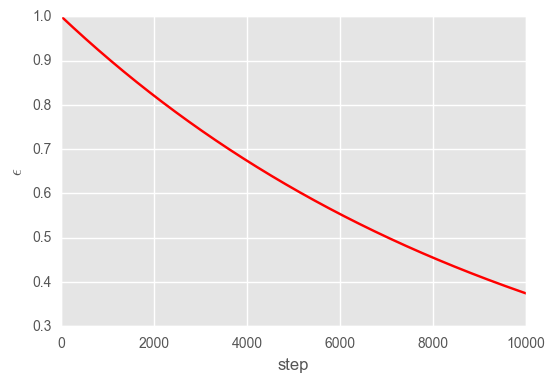

In [10]:
def epsilon(steps):
    return MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)
plt.plot(range(10000), [epsilon(x) for x in range(10000)], 'r')
plt.xlabel('step');plt.ylabel('$\epsilon$')

We are now ready to train our agent using **DQN**. Note this would take anywhere between 2-10 min and we stop whenever the learner hits the average reward of 200 over past 50 batches. One would get better results if they could train the learner until say one hits a reward of 200 or higher for say larger number of runs. This is left as an exercise.

Episode: 50, Average reward for episode 18.500000.
Episode: 100, Average reward for episode 16.200000.
Episode: 150, Average reward for episode 17.280000.
Episode: 200, Average reward for episode 15.900000.
Episode: 250, Average reward for episode 13.880000.
Episode: 300, Average reward for episode 14.540000.
Episode: 350, Average reward for episode 13.520000.
Episode: 400, Average reward for episode 13.200000.
Episode: 450, Average reward for episode 12.800000.
Episode: 500, Average reward for episode 12.600000.
Episode: 550, Average reward for episode 12.480000.
Episode: 600, Average reward for episode 13.980000.
Episode: 650, Average reward for episode 12.280000.
Episode: 700, Average reward for episode 11.660000.
Episode: 750, Average reward for episode 11.580000.
Episode: 800, Average reward for episode 11.500000.
Episode: 850, Average reward for episode 11.700000.
Episode: 900, Average reward for episode 10.840000.
Episode: 950, Average reward for episode 11.740000.
Episode: 1000

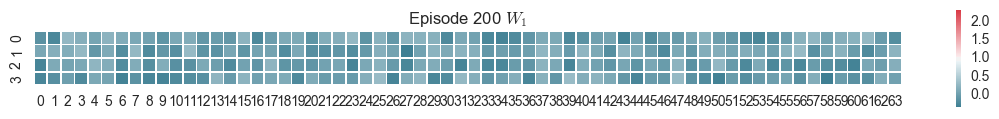

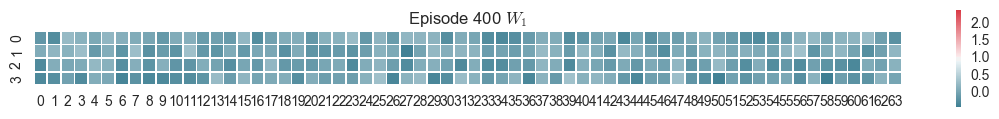

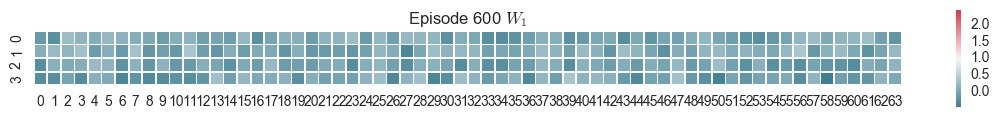

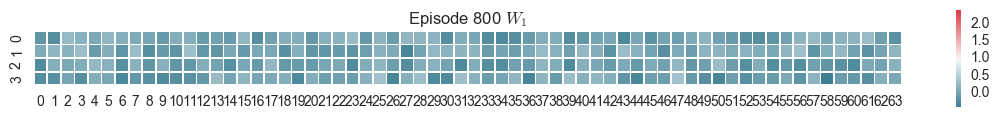

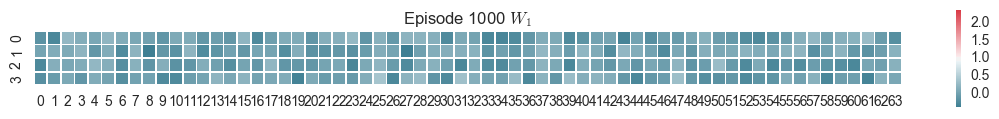

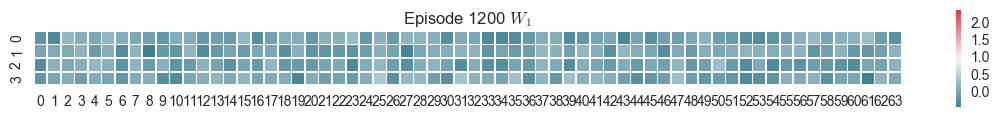

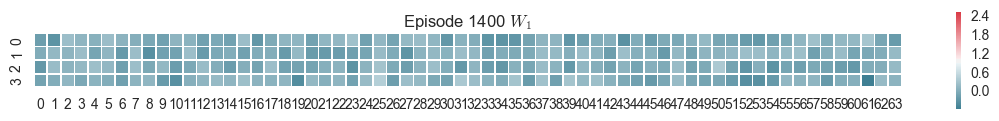

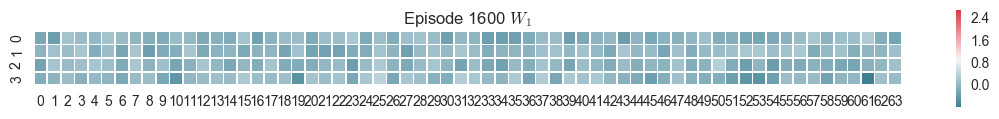

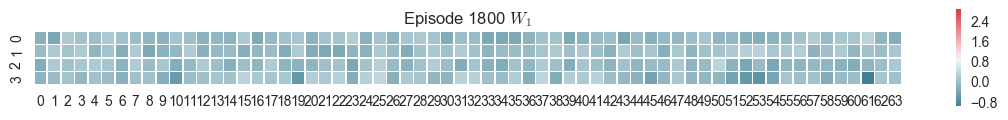

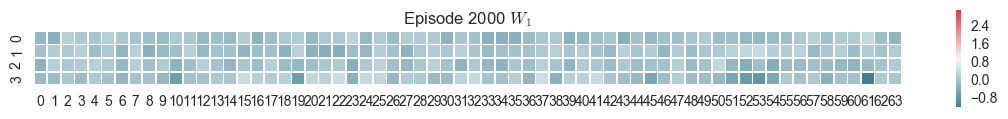

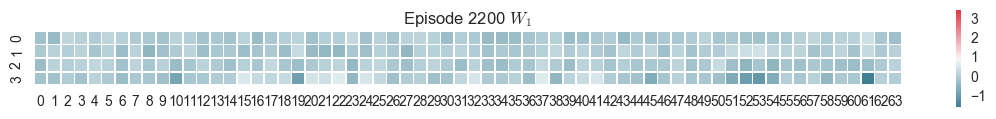

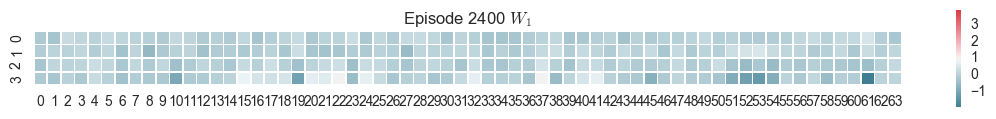

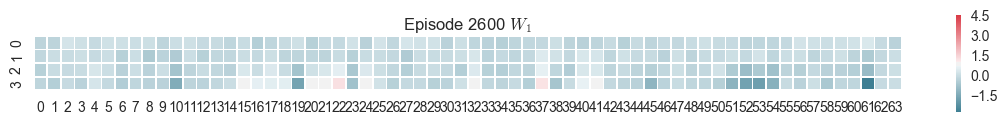

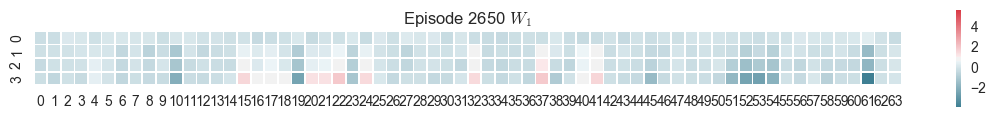

In [11]:
def run(agent):
    s = env.reset()
    R = 0 

    while True:            
        #env.render()

        # CNTK: explicitly setting to float32
        a = agent.act(s.astype(np.float32))

        s_, r, done, info = env.step(a)

        if done: # terminal state
            s_ = None

        agent.observe((s, a, r, s_))
        agent.replay()            

        s = s_
        R += r

        if done:
            return R

agent = Agent()

episode_number = 0
reward_sum = 0
while episode_number<3000:
    reward_sum += run(agent)
    episode_number += 1
    if episode_number % BATCH_SIZE_BASELINE == 0:
        print('Episode: %d, Average reward for episode %f.' % (episode_number, 
                                                               reward_sum / BATCH_SIZE_BASELINE))
        if episode_number%200==0:
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))
        if reward_sum / BATCH_SIZE_BASELINE > 200:
            print('Task solved in %d episodes' % episode_number)
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))            
            break
        reward_sum = 0
agent.brain.model.save_model('dqn.mod', False)

If you run it, you should see something like

```[2016-10-26 22:06:25,436] Making new env: CartPole-v0
Episode: 50, Average reward for episode 23.700000.
Episode: 100, Average reward for episode 18.720000.
Episode: 150, Average reward for episode 17.960000.
...
Episode: 1750, Average reward for episode 100.180000.
Episode: 1800, Average reward for episode 111.380000.
Episode: 1850, Average reward for episode 207.240000.
Task solved in 1850 episodes```

#### Task 1.1
Rewrite the model without using the layer lib.
#### Task 1.2
Play with different [learners](https://cntk.ai/pythondocs/cntk.learner.html?highlight=learner#module-cntk.learner). Which one works better? Worse? Think about which parameters you would need to adapt when switching from one learner to the other.

### Running the DQN model

In [12]:
import cntk as C
env = gym.make('CartPole-v0')

num_episodes = 10  # number of episodes to run

modelPath = 'dqn.mod'
root = C.load_model(modelPath)
observation = env.reset()  # reset environment for new episode
done = False
for i_episode in range(num_episodes):
    print(i_episode)
    while not done:
        #env.render()
        action = np.argmax(root.eval(observation.astype(np.float32)))
        observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()  # reset environment for new episode    

[2016-11-10 16:01:55,791] Making new env: CartPole-v0


0
1
2
3
4
5
6
7
8
9


# Part 2: Policy gradient
**Goal:** 
\begin{equation}\text{maximize } E [R | \pi_\theta]
\end{equation}

**Approach:**
1. Collect experience (sample a bunch of trajectories through $(s,a)$ space)
2. Update the policy so that _good_ experiences become more probable

**Difference to DQN: **
 * we don't consider single $(s,a,r,s')$ transitions, but rather use whole episodes for the gradient updates
 * our parameters directly model the policy (output is an action probability), whereas in DQN they model the value function (output is raw score)

#### Rewards:
Remember, we get +1 reward for every time step, in which we still were in the game. 

The problem: we normally do not know, which action led to a continuation of the game, and which was actually a bad one. Our simple heuristic: actions in the beginning of the episode are good, and those towards the end are likely bad (they led to losing the game after all).

In [13]:
def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

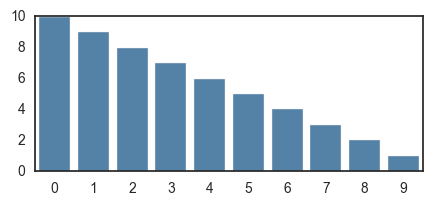

In [14]:
discounted_epr = discount_rewards(np.ones(10))
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr, color="steelblue")

We normalize the rewards so that they tank below zero towards the end. gamma controls how late the rewards tank.

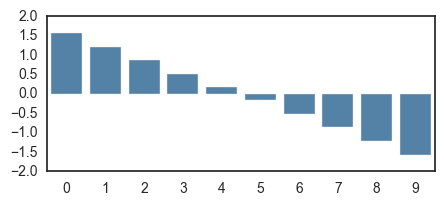

In [15]:
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue")

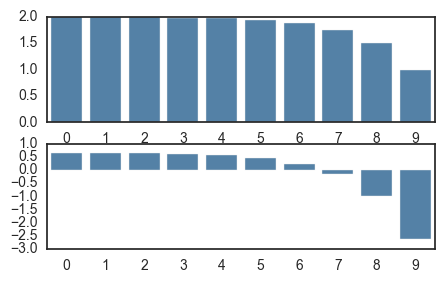

In [16]:
discounted_epr = discount_rewards(np.ones(10), gamma=0.5)
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(2, figsize=(5,3))
sns.barplot(list(range(10)), discounted_epr, color="steelblue", ax=ax[0])
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue", ax=ax[1])

### Setting up the model
\begin{equation}
l_1 = relu( x W_1 + b_1) \\
l_2 = l_1 W_2 + b_2 \\
\pi(a|s) = sigmoid(l_2)
\end{equation}

Note: in policy gradient approach, the output of the dense layer is mapped into to a 0-1 range via the sigmoid function.

In [18]:
import cntk as C 

TOTAL_EPISODES = 10000
D = 4  # input dimensionality
H = 10 # number of hidden layer neurons

observations = C.input_variable(shape=STATE_COUNT, dtype=np.float32, name="obs")

W1 = C.parameter(shape=(STATE_COUNT, H), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=H, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)

W2 = C.parameter(shape=(H, ACTION_COUNT), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=ACTION_COUNT, name="b2")
score = C.times(layer1, W2) + b2
# Until here it was similar to DQN

probability = C.sigmoid(score, name="prob")

**Policy Search**: The optimal policy search can be carried out with either gradient free approaches or by computing gradients over the policy space ($\pi_\theta$) which is parameterized by $\theta$. In this tutorial, we use the classic forward (`loss.forward`) and back (`loss.backward`) propagation of errors over the parameterized space $\theta$. In this case, $\theta = \{W_1, b_1, W_2, b_2\}$, our model parameters.  

In [ ]:
input_y = C.input_variable(shape=1, dtype=np.float32, name="input_y")
advantages = C.input_variable(shape=1, dtype=np.float32, name="advt")

loss = -C.reduce_mean(C.log(C.square(input_y - probability) + 1e-4) * advantages, axis=0, name='loss')

lr = 0.001 
sgd = C.sgd([W1, W2], lr)

gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

xs, hs, label, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1

observation = env.reset()

while episode_number <= TOTAL_EPISODES:
    x = np.reshape(observation, [1, STATE_COUNT]).astype(np.float32)

    # Run the policy network and get an action to take.
    prob = probability.eval(arguments={observations: x})[0][0][0]
    action = 1 if np.random.uniform() < prob else 0

    xs.append(x)  # observation
    # grad that encourages the action that was taken to be taken

    y = 1 if action == 0 else 0  # a "fake label"
    label.append(y)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += float(reward)

    # Record reward (has to be done after we call step() to get reward for previous action)
    drs.append(float(reward))

    if done:
        # Stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        epl = np.vstack(label).astype(np.float32)
        epr = np.vstack(drs).astype(np.float32)
        xs, label, drs = [], [], []  # reset array memory

        # Compute the discounted reward backwards through time.
        discounted_epr = discount_rewards(epr)
        # Size the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        # Forward pass
        arguments = {observations: epx, input_y: epl, advantages: discounted_epr}
        state, outputs_map = loss.forward(arguments, outputs=loss.outputs, 
                                          keep_for_backward=loss.outputs)
        
        # Backward psas
        root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
        vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

        for var, grad in vargrads_map.items():
            gradBuffer[var.name] += grad

        # Wait for some batches to finish to reduce noise
        if episode_number % BATCH_SIZE == 0:
            grads = {W1: gradBuffer['W1'].astype(np.float32), 
                     W2: gradBuffer['W2'].astype(np.float32)}
            updated = sgd.update(grads, BATCH_SIZE)

            # reset the gradBuffer
            gradBuffer = dict((var.name, np.zeros(shape=var.shape)) 
                              for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

            print('Episode: %d. Average reward for episode %f.' % (episode_number, reward_sum / BATCH_SIZE))

            if reward_sum / BATCH_SIZE > 200:
                print('Task solved in: %d ' % episode_number)
                break

            reward_sum = 0

        observation = env.reset()  # reset env
        episode_number += 1
agent.brain.model.save_model('pg.mod', False)

Episode: 64. Average reward for episode 19.156250.


# Solutions
#### Solution 1.1

In [ ]:
observation = input_variable(STATE_COUNT, np.float32, name="s")

W1 = parameter(shape=(STATE_COUNT, H), init=glorot_uniform(), name="W1")
b1 = parameter(shape=H, name="b1")
layer1 = relu(times(observation, W1) + b1)
W2 = parameter(shape=(H, ACTION_COUNT), init=glorot_uniform(), name="W2")
b2 = parameter(shape=ACTION_COUNT, name="b2")
model = times(layer1, W2) + b2
W1.shape, b1.shape, W2.shape, b2.shape, model.shape